In [1]:
import numpy as np
import pickle
import os
import sys
import time
import itertools as it

import matplotlib.pyplot as plt
from SALib.sample import saltelli

import tqdm
import contextlib

# sys.path.append('./GDMaps_PCE/')
from DimensionReduction import Grassmann
from DimensionReduction import DiffusionMaps
from GDMaps_PCE_GSA import *

from UQpy.distributions import Normal, Uniform, JointIndependent

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
def PCE_LAR_model_selection(x, g, n_params, dist_obj, max_degree):
  
    n_dcoords = g.shape[1]
    
    # construct total-degree polynomial basis
    polynomial_basis = TotalDegreeBasis(dist_obj, max_degree)

    least_squares = LeastSquareRegression()
    pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

    xx_train, xx_test, \
        gg_train, gg_test = train_test_split(x, g, train_size=2 / 3, random_state=1)

    error_pceLAR = np.zeros((n_dcoords))
    LOO_pceLAR   = np.zeros((n_dcoords))
    pceLAR_fo_si = np.zeros((n_params, n_dcoords))
    pceLAR_to_si = np.zeros((n_params, n_dcoords))

    for i in range(n_dcoords):        
        pce.fit(xx_train, gg_train[:, i])
        # Lars model selection
        print('Size of the full set of PCE basis:', polynomial_basis.polynomials_number)

        target_error = 1
        CheckOverfitting = True
        pceLAR = polynomial_chaos.regressions.LeastAngleRegression.model_selection(pce, 
                                                                                   target_error, 
                                                                                   CheckOverfitting)

        print('Size of the LAR PCE basis:', pceLAR.polynomial_basis.polynomials_number)

        error_pceLAR[i] = ErrorEstimation(surr_object=pceLAR).validation(xx_test, gg_test[:, i])           
        LOO_pceLAR[i]   = pceLAR.leaveoneout_error()

        print('Leave-one-out cross validation on ED:', pceLAR.leaveoneout_error())

        pceLAR_sensitivity = PceSensitivity(pceLAR)
        pceLAR_sensitivity.run()

        LAR_sobol_first = pceLAR_sensitivity.first_order_indices
        LAR_sobol_total = pceLAR_sensitivity.total_order_indices

        pceLAR_fo_si[:, i] = LAR_sobol_first.T
        pceLAR_to_si[:, i] = LAR_sobol_total.T
        
    return (error_pceLAR, LOO_pceLAR, pceLAR_fo_si, pceLAR_to_si)

In [4]:
# problem definition
PROBLEM = {
    "num_vars" : 5,
    "names"    : ["theta",
                  "gain_right",
                  "saving_prop",
                  "prob_left",
                  "alpha"],
    "bounds"   : [[0.01, 0.20],
                  [1.70, 8.00],
                  [0.70, 0.80],
                  [0.30, 0.45],
                  [2.00, 12.0]]
}

# generate Saltelli samples
NUM_SAMPLES = 1024
X = saltelli.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)
print(f'Problem bounds: {PROBLEM["bounds"]}')

pdf1 = Uniform(loc=0.01, scale=0.19) 
pdf2 = Uniform(loc=1.70, scale=6.30)  
pdf3 = Uniform(loc=0.70, scale=0.10)  
pdf4 = Uniform(loc=0.30, scale=0.15)  
pdf5 = Uniform(loc=2.00, scale=10.00)  
margs = [pdf1, pdf2, pdf3, pdf4, pdf5]
joint = JointIndependent(marginals=margs)

Problem bounds: [[0.01, 0.2], [1.7, 8.0], [0.7, 0.8], [0.3, 0.45], [2.0, 12.0]]


# Micro

In [8]:
micro_files = sorted([f for f in os.listdir("../../micro_gsa/") if "micro" in f and ".pickle" in f])

d_coords = []
for f in micro_files:
    with open("../../micro_gsa/" + f, "rb") as f:
        _, _, _, g_diff_runs, _, _ = pickle.load(f)
    d_coords.append(g_diff_runs[0])
    
n_params = X.shape[1]
n_dcoords = d_coords[0].shape[1]
n_runs = len(d_coords)
n_params, n_dcoords, n_runs

(5, 3, 20)

In [10]:
s_max = [15]

LAR_fo_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_to_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_error = np.zeros((n_runs, len(s_max), n_dcoords))
LAR_LOO   = np.zeros((n_runs, len(s_max), n_dcoords))

for run in range(n_runs):
    print("Run:", run)
    g = d_coords[run]

    for i, s in enumerate(s_max):
        print("Max polynomial degree:", s)

        start_time = time.time()
        LAR_result = PCE_LAR_model_selection(x=X, 
                                             g=g, 
                                             n_params=n_params, 
                                             dist_obj=joint, 
                                             max_degree=s)
        
        LAR_fo_si[run, i] = LAR_result[2]
        LAR_to_si[run, i] = LAR_result[3]
        LAR_error[run, i] = LAR_result[0]
        LAR_LOO[run, i]   = LAR_result[1]
        
        print("--- PCE-LAR took %s seconds ---" % (time.time() - start_time))
        
        RES = [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO]
        with open("PCE_LAR_RESULTS_micro.pickle", "wb") as f:
            pickle.dump(RES, f)

Run: 0
Max polynomial degree: 15
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 178
Leave-one-out cross validation on ED: 0.2334589
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 952
Leave-one-out cross validation on ED: 0.6444798
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 982
Leave-one-out cross validation on ED: 0.5776413
--- PCE-LAR took 2130.7330570220947 seconds ---
Run: 1
Max polynomial degree: 15
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 194
Leave-one-out cross validation on ED: 0.2841544
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 957
Leave-one-out cross validation on ED: 0.6211126
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 978
Leave-one-out cross validation on ED: 0.6147188
--- PCE-LAR took 2540.8796648979187 seconds ---
Run: 2
Max polynomial degree: 15
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 158
Leave-one-out

Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 927
Leave-one-out cross validation on ED: 0.6321495
--- PCE-LAR took 2442.0540730953217 seconds ---
Run: 19
Max polynomial degree: 15
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 194
Leave-one-out cross validation on ED: 0.2364116
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 975
Leave-one-out cross validation on ED: 0.5907708
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 978
Leave-one-out cross validation on ED: 0.5758775
--- PCE-LAR took 2251.4837839603424 seconds ---


# Meso

In [263]:
meso_files = sorted([f for f in os.listdir("GDMAPS_results/") if "meso" in f])

d_coords = []
for f in meso_files:
    with open("GDMAPS_results/" + f, "rb") as f:
        _, _, _, g_diff_runs, _, _ = pickle.load(f)
    d_coords.append(g_diff_runs[0])

n_params = X.shape[1]
n_dcoords = d_coords[0].shape[1]
n_runs = len(d_coords)
n_params, n_dcoords, n_runs

(6, 3, 10)

In [ ]:
s_max = [6, 12]

LAR_fo_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_to_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_error = np.zeros((n_runs, len(s_max), n_dcoords))
LAR_LOO   = np.zeros((n_runs, len(s_max), n_dcoords))

for run in range(n_runs):
    print("Run:", run)
    g = d_coords[run]

    for i, s in enumerate(s_max):
        print("Max polynomial degree:", s)

        start_time = time.time()
        LAR_result = PCE_LAR_model_selection(x=x, 
                                             g=g, 
                                             n_params=n_params, 
                                             dist_obj=joint, 
                                             max_degree=s)

        LAR_fo_si[run, i] = LAR_result[2]
        LAR_to_si[run, i] = LAR_result[3]
        LAR_error[run, i] = LAR_result[0]
        LAR_LOO[run, i]   = LAR_result[1]

        print("--- PCE-LAR took %s seconds ---" % (time.time() - start_time))

        RES = [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO]
        with open("PCE_LAR_RESULTS_meso.pickle", "wb") as f:
            pickle.dump(RES, f)

# Macro

In [4]:
global_files = sorted([f for f in os.listdir("../GDMAPS_results/") if "macro" in f])

d_coords = []
for f in global_files:
    with open("../GDMAPS_results/" + f, "rb") as f:
        _, _, _, g_diff_runs, _, _ = pickle.load(f)
    d_coords.append(g_diff_runs[0])
    
n_params = X.shape[1]
n_dcoords = d_coords[0].shape[1]
n_runs = len(d_coords)
n_params, n_dcoords, n_runs

(5, 3, 20)

In [ ]:
s_max = [18]

LAR_fo_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_to_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_error = np.zeros((n_runs, len(s_max), n_dcoords))
LAR_LOO   = np.zeros((n_runs, len(s_max), n_dcoords))

for run in range(n_runs):
    print("Run:", run)
    g = d_coords[run]

    for i, s in enumerate(s_max):
        print("Max polynomial degree:", s)

        start_time = time.time()
        LAR_result = PCE_LAR_model_selection(x=X, 
                                             g=g, 
                                             n_params=n_params, 
                                             dist_obj=joint, 
                                             max_degree=s)
        
        print("--- PCE-LAR took %s seconds ---" % (time.time() - start_time))
        
        LAR_fo_si[run, i] = LAR_result[2]
        LAR_to_si[run, i] = LAR_result[3]
        LAR_error[run, i] = LAR_result[0]
        LAR_LOO[run, i]   = LAR_result[1]
        
        RES = [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO]
        with open(f"PCE_LAR_RESULTS_macro_{s}.pickle", "wb") as f:
            pickle.dump(RES, f)

# Micro Results

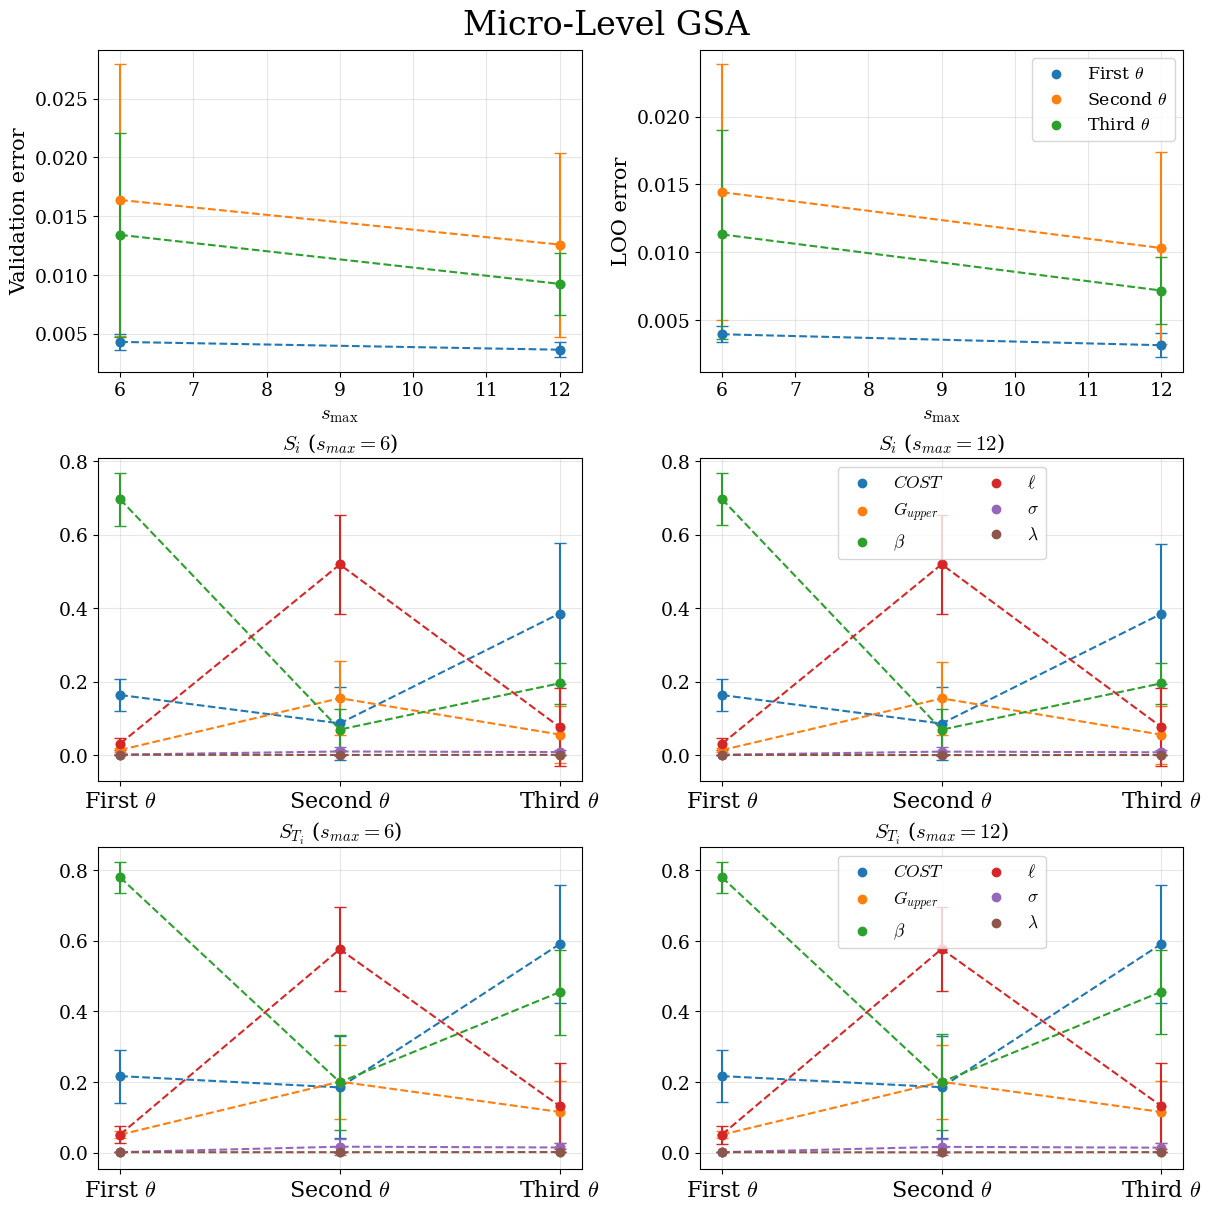

In [25]:
s_max = [6,12]

with open("../data/PCE_LAR_RESULTS_micro.pickle", 'rb') as f:
    [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO] = pickle.load(f)
    
param_names = [r"$COST$", r"$G_{upper}$", r"$\beta$", r"$\ell$", r"$\sigma$", r"$\lambda$"]

n_dcoords = 3

fig, axs = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True)

theta_labels = [r"First $\theta$", r"Second $\theta$", r"Third $\theta$"]

# ERROR
for d in range(n_dcoords):
    axs[0][0].scatter(s_max, LAR_error.mean(axis=0)[:, d], label=theta_labels[d])
    axs[0][0].errorbar(s_max, LAR_error.mean(axis=0)[:, d],
                      LAR_error.std(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[0][1].scatter(s_max, LAR_LOO.mean(axis=0)[:, d], label=theta_labels[d])
    axs[0][1].errorbar(s_max, LAR_LOO.mean(axis=0)[:, d],
                      LAR_LOO.std(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[0][1].legend()
for i in range(3):
    axs[0][0].set(ylabel=r'Validation error', xlabel=r'$s_{\max}$')
    axs[0][1].set(ylabel=r'LOO error', xlabel=r'$s_{\max}$')

# First order si
for i, param in enumerate(param_names):
    
    axs[1][0].scatter([1,2,3],LAR_fo_si.mean(axis=0)[0][i])    
    axs[1][0].errorbar([1,2,3], LAR_fo_si.mean(axis=0)[0][i],
                      LAR_fo_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[1][0].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
    axs[1][0].set_title(r"$S_i$ ($s_{max}=6$)")
    
    axs[1][1].scatter([1,2,3],LAR_fo_si.mean(axis=0)[1][i], label=param_names[i])    
    axs[1][1].errorbar([1,2,3], LAR_fo_si.mean(axis=0)[1][i],
                      LAR_fo_si.std(axis=0, ddof=1)[1][i],
                      linestyle='--', marker='o', capsize=4)
    axs[1][1].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
    axs[1][1].set_title(r"$S_i$ ($s_{max}=12$)")
    axs[1][1].legend(ncol=2)

# Total order si
for i, param in enumerate(param_names):
    
    axs[2][0].scatter([1,2,3],LAR_to_si.mean(axis=0)[0][i])    
    axs[2][0].errorbar([1,2,3], LAR_to_si.mean(axis=0)[0][i],
                      LAR_to_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[2][0].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
    axs[2][0].set_title(r"$S_{T_i}$ ($s_{max}=6$)")
    
    axs[2][1].scatter([1,2,3],LAR_to_si.mean(axis=0)[1][i], label=param_names[i])    
    axs[2][1].errorbar([1,2,3], LAR_to_si.mean(axis=0)[1][i],
                      LAR_to_si.std(axis=0, ddof=1)[1][i],
                      linestyle='--', marker='o', capsize=4)
    axs[2][1].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
    axs[2][1].set_title(r"$S_{T_i}$ ($s_{max}=12$)")
    axs[2][1].legend(ncol=2)

plt.suptitle("Micro-Level GSA", fontsize=24)
plt.show()

# Meso Results

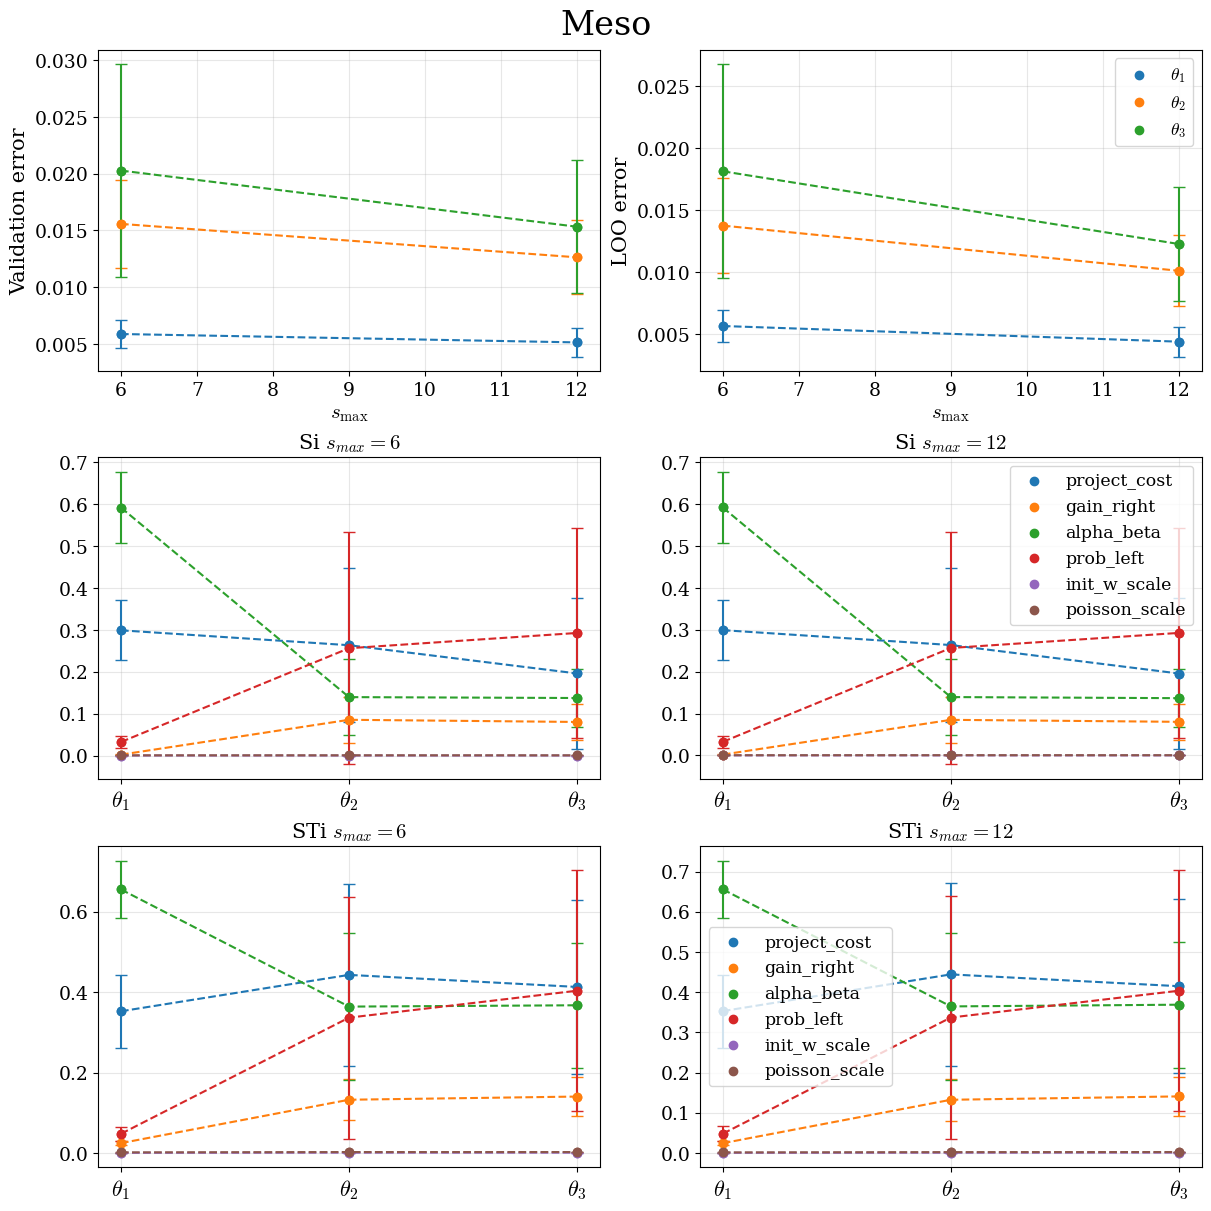

In [306]:
with open("PCE_LAR_RESULTS_meso.pickle", 'rb') as f:
    [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO] = pickle.load(f)
    
param_names = ["project_cost", "gain_right", "alpha_beta", "prob_left", "init_w_scale", "poisson_scale"]
n_dcoords = 3

fig, axs = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True)

# ERROR
for d in range(n_dcoords):
    axs[0][0].scatter(s_max, LAR_error.mean(axis=0)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[0][0].errorbar(s_max, LAR_error.mean(axis=0)[:, d],
                      LAR_error.std(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[0][1].scatter(s_max, LAR_LOO.mean(axis=0)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[0][1].errorbar(s_max, LAR_LOO.mean(axis=0)[:, d],
                      LAR_LOO.std(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[0][1].legend()
for i in range(3):
    axs[0][0].set(ylabel=r'Validation error', xlabel=r'$s_{\max}$')
    axs[0][1].set(ylabel=r'LOO error', xlabel=r'$s_{\max}$')

# First order si
for i, param in enumerate(param_names):
    
    axs[1][0].scatter([1,2,3],LAR_fo_si.mean(axis=0)[0][i])    
    axs[1][0].errorbar([1,2,3], LAR_fo_si.mean(axis=0)[0][i],
                      LAR_fo_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[1][0].set_xticks([1,2,3], labels=[rf"$\theta_{i}$" for i in range(1,4)], fontsize=16)
    axs[1][0].set_title(r"Si $s_{max}=6$")
    
    axs[1][1].scatter([1,2,3],LAR_fo_si.mean(axis=0)[1][i], label=param_names[i])    
    axs[1][1].errorbar([1,2,3], LAR_fo_si.mean(axis=0)[1][i],
                      LAR_fo_si.std(axis=0, ddof=1)[1][i],
                      linestyle='--', marker='o', capsize=4)
    axs[1][1].set_xticks([1,2,3], labels=[rf"$\theta_{i}$" for i in range(1,4)], fontsize=16)
    axs[1][1].set_title(r"Si $s_{max}=12$")
    axs[1][1].legend()

# Total order si
for i, param in enumerate(param_names):
    
    axs[2][0].scatter([1,2,3],LAR_to_si.mean(axis=0)[0][i])    
    axs[2][0].errorbar([1,2,3], LAR_to_si.mean(axis=0)[0][i],
                      LAR_to_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[2][0].set_xticks([1,2,3], labels=[rf"$\theta_{i}$" for i in range(1,4)], fontsize=16)
    axs[2][0].set_title(r"STi $s_{max}=6$")
    
    axs[2][1].scatter([1,2,3],LAR_to_si.mean(axis=0)[1][i], label=param_names[i])    
    axs[2][1].errorbar([1,2,3], LAR_to_si.mean(axis=0)[1][i],
                      LAR_to_si.std(axis=0, ddof=1)[1][i],
                      linestyle='--', marker='o', capsize=4)
    axs[2][1].set_xticks([1,2,3], labels=[rf"$\theta_{i}$" for i in range(1,4)], fontsize=16)
    axs[2][1].set_title(r"STi $s_{max}=12$")
    axs[2][1].legend()
    
plt.suptitle("Meso", fontsize=24)
plt.show()

# Global Results

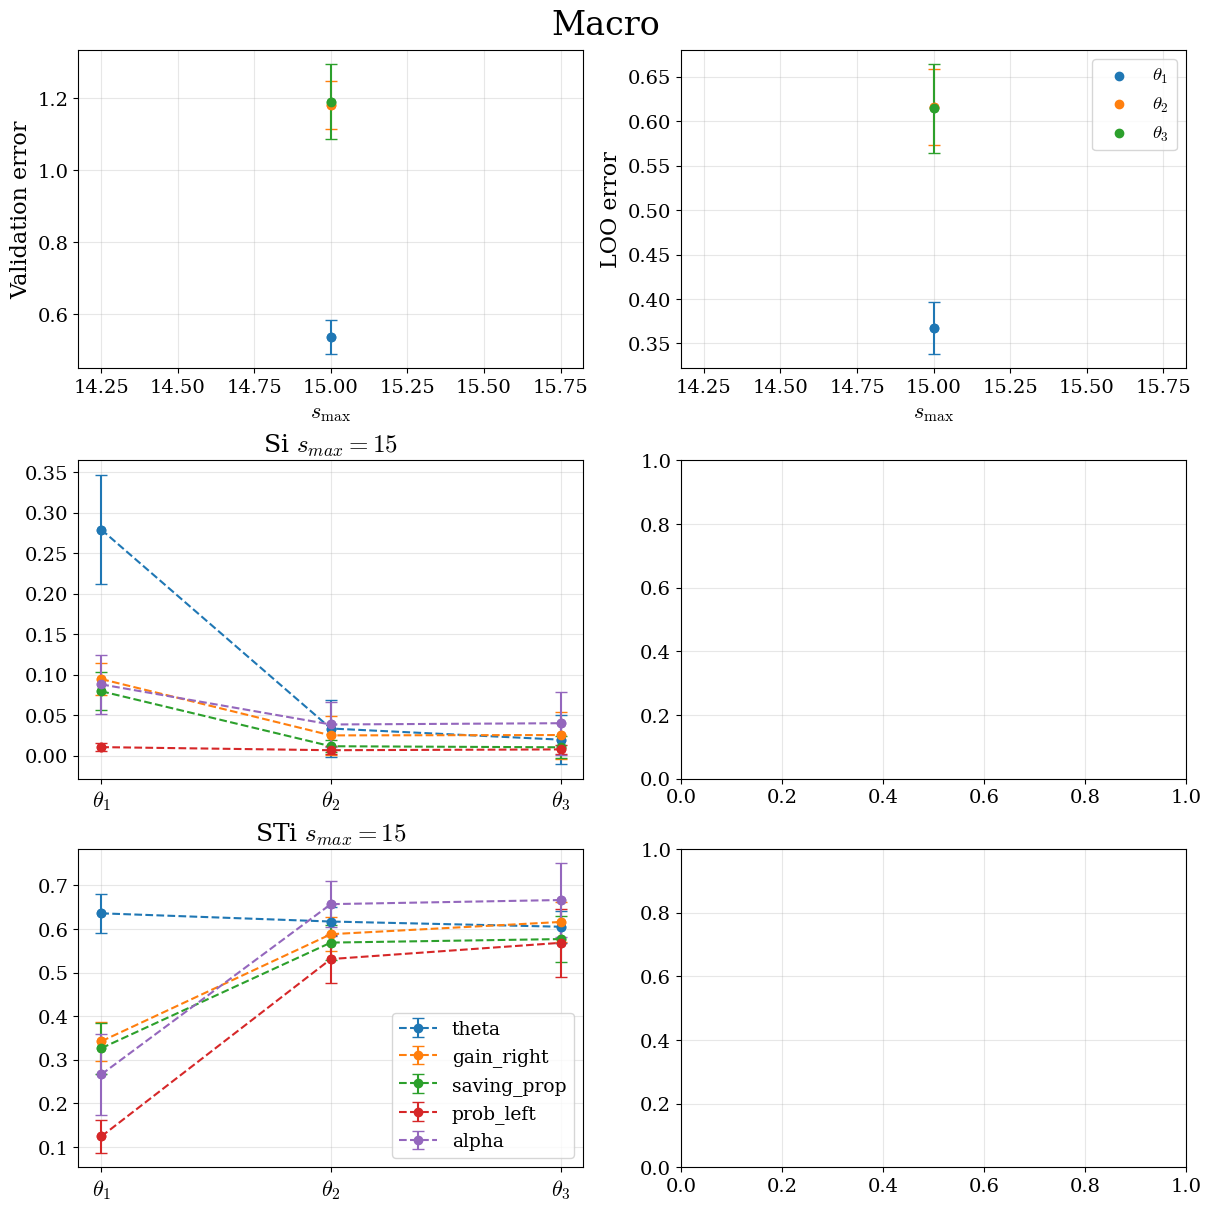

In [26]:
s_max = [15]

with open("PCE_LAR_RESULTS_macro_15.pickle", 'rb') as f:
    [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO] = pickle.load(f)
    
param_names = ["theta", "gain_right", "saving_prop", "prob_left", "alpha"]
n_dcoords = 3

fig, axs = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True)

# ERROR
for d in range(n_dcoords):
    axs[0][0].scatter(s_max, LAR_error.mean(axis=0)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[0][0].errorbar(s_max, LAR_error.mean(axis=0)[:, d],
                      LAR_error.std(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[0][1].scatter(s_max, LAR_LOO.mean(axis=0)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[0][1].errorbar(s_max, LAR_LOO.mean(axis=0)[:, d],
                      LAR_LOO.std(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[0][1].legend()
for i in range(3):
    axs[0][0].set(ylabel=r'Validation error', xlabel=r'$s_{\max}$')
    axs[0][1].set(ylabel=r'LOO error', xlabel=r'$s_{\max}$')

# First order si
for i, param in enumerate(param_names):
    
    axs[1][0].scatter([1,2,3],LAR_fo_si.mean(axis=0)[0][i])    
    axs[1][0].errorbar([1,2,3], LAR_fo_si.mean(axis=0)[0][i],
                      LAR_fo_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[1][0].set_xticks([1,2,3], labels=[rf"$\theta_{i}$" for i in range(1,4)], fontsize=16)
    axs[1][0].set_title(r"Si $s_{max}=15$")
    
#     axs[1][1].scatter([1,2,3],LAR_fo_si.mean(axis=0)[1][i], label=param_names[i])    
#     axs[1][1].errorbar([1,2,3], LAR_fo_si.mean(axis=0)[1][i],
#                       LAR_fo_si.std(axis=0, ddof=1)[1][i],
#                       linestyle='--', marker='o', capsize=4)
#     axs[1][1].set_xticks([1,2,3], labels=[rf"$\theta_{i}$" for i in range(1,4)], fontsize=16)
#     axs[1][1].set_title(r"Si $s_{max}=12$")
#     axs[1][1].legend()

# Total order si
for i, param in enumerate(param_names):
    
    axs[2][0].scatter([1,2,3],LAR_to_si.mean(axis=0)[0][i])    
    axs[2][0].errorbar([1,2,3], LAR_to_si.mean(axis=0)[0][i],
                      LAR_to_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4, label=param_names[i])
    axs[2][0].set_xticks([1,2,3], labels=[rf"$\theta_{i}$" for i in range(1,4)], fontsize=16)
    axs[2][0].set_title(r"STi $s_{max}=15$")
    axs[2][0].legend()
    
#     axs[2][1].scatter([1,2,3],LAR_to_si.mean(axis=0)[1][i], label=param_names[i])    
#     axs[2][1].errorbar([1,2,3], LAR_to_si.mean(axis=0)[1][i],
#                       LAR_to_si.std(axis=0, ddof=1)[1][i],
#                       linestyle='--', marker='o', capsize=4)
#     axs[2][1].set_xticks([1,2,3], labels=[rf"$\theta_{i}$" for i in range(1,4)], fontsize=16)
#     axs[2][1].set_title(r"STi $s_{max}=12$")
#     axs[2][1].legend()
    
plt.suptitle("Macro", fontsize=24)
plt.show()

# Combine $S_i, S_{T_i}$ for micro, meso, macro

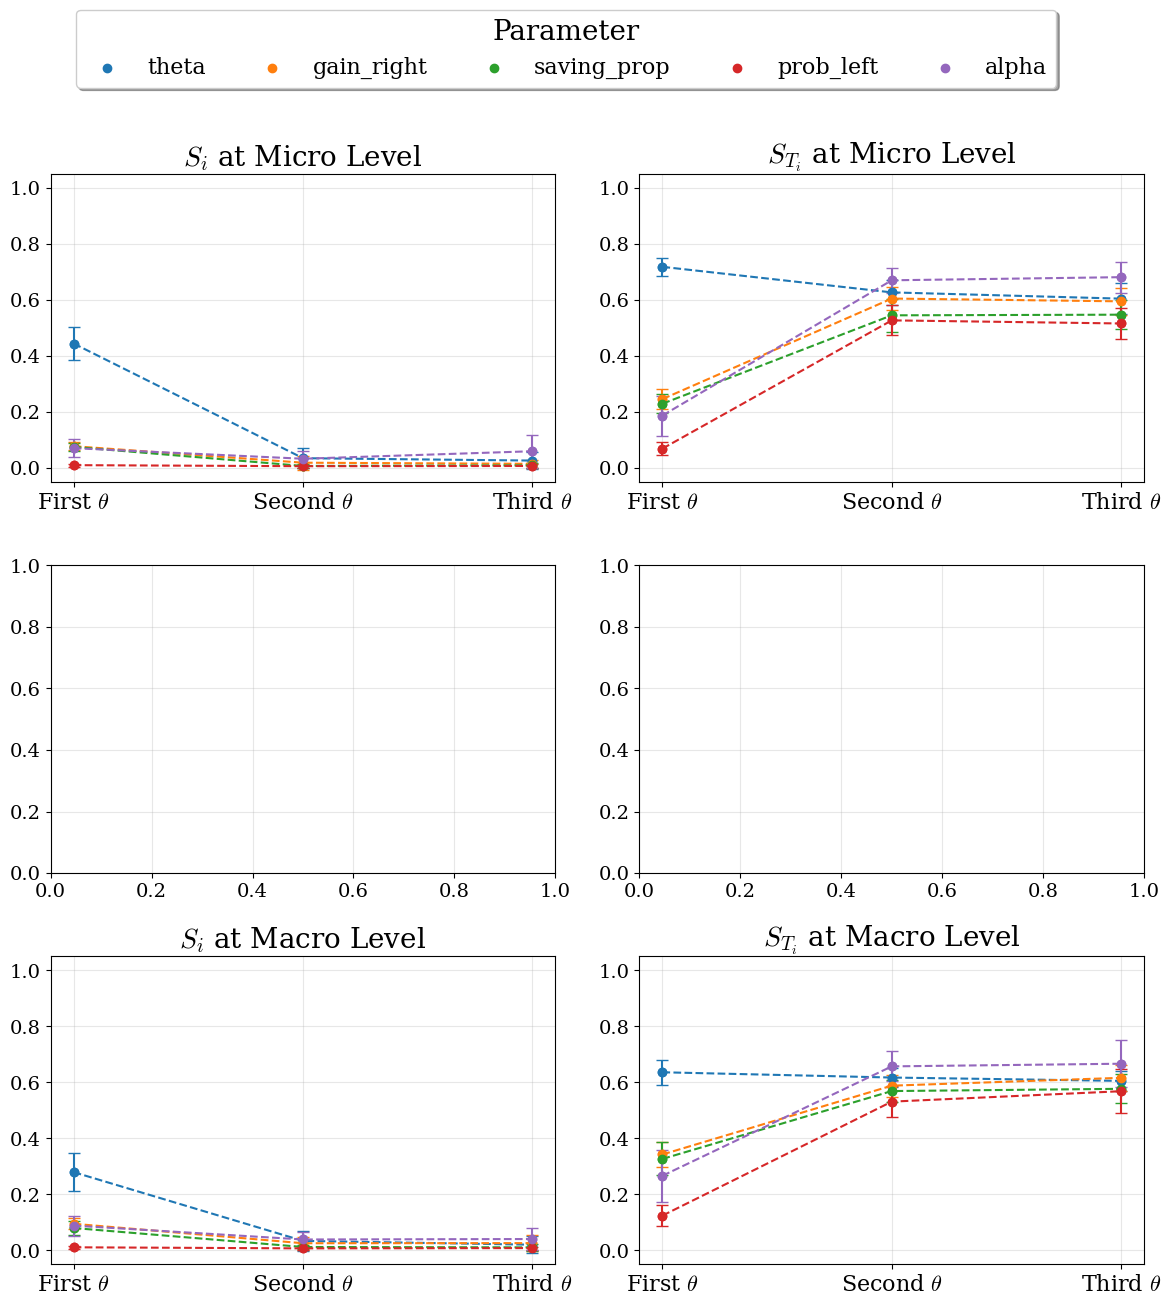

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(12,12))
param_names = ["theta", "gain_right", "saving_prop", "prob_left", "alpha"]
theta_labels = [r"First $\theta$", r"Second $\theta$", r"Third $\theta$"]


# MICRO
with open("PCE_LAR_RESULTS_micro.pickle", 'rb') as f:
    [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO] = pickle.load(f)
# First order si
for i, param in enumerate(param_names):
    axs[0][0].scatter([1,2,3],LAR_fo_si.mean(axis=0)[0][i], label=param_names[i])    
    axs[0][0].errorbar([1,2,3], LAR_fo_si.mean(axis=0)[0][i],
                      LAR_fo_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[0][0].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
    axs[0][0].set_title(r"$S_i$ at Micro Level", fontsize=20)
    axs[0][0].set_ylim(-0.05,1.05)
# Total order si
for i, param in enumerate(param_names):
    axs[0][1].scatter([1,2,3],LAR_to_si.mean(axis=0)[0][i], label=param_names[i])    
    axs[0][1].errorbar([1,2,3], LAR_to_si.mean(axis=0)[0][i],
                      LAR_to_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[0][1].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
    axs[0][1].set_title(r"$S_{T_i}$ at Micro Level", fontsize=20)
    axs[0][1].set_ylim(-0.05,1.05)
    
# # MESO
# with open("../data/sda_PCE_LAR_RESULTS_meso.pickle", 'rb') as f:
#     [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO] = pickle.load(f)
# # First order si
# for i, param in enumerate(param_names):
#     axs[1][0].scatter([1,2,3],LAR_fo_si.mean(axis=0)[1][i], label=param_names[i], color=colors[i])    
#     axs[1][0].errorbar([1,2,3], LAR_fo_si.mean(axis=0)[1][i],
#                       LAR_fo_si.std(axis=0, ddof=1)[1][i],
#                       linestyle='--', marker='o', capsize=4, color=colors[i])
#     axs[1][0].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
#     axs[1][0].set_title(r"$S_i$ at Meso Level", fontsize=20)
#     axs[1][0].set_ylim(-0.05,1.05)
# # Total order si
# for i, param in enumerate(param_names):
#     axs[1][1].scatter([1,2,3],LAR_to_si.mean(axis=0)[1][i], label=param_names[i], color=colors[i])    
#     axs[1][1].errorbar([1,2,3], LAR_to_si.mean(axis=0)[1][i],
#                       LAR_to_si.std(axis=0, ddof=1)[1][i],
#                       linestyle='--', marker='o', capsize=4, color=colors[i])
#     axs[1][1].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
#     axs[1][1].set_title(r"$S_{T_i}$ at Meso Level", fontsize=20)
#     axs[1][1].set_ylim(-0.05,1.05)

# MACRO
with open("PCE_LAR_RESULTS_macro_15.pickle", 'rb') as f:
    [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO] = pickle.load(f)
# First order si
for i, param in enumerate(param_names):
    axs[2][0].scatter([1,2,3],LAR_fo_si.mean(axis=0)[0][i], label=param_names[i])    
    axs[2][0].errorbar([1,2,3], LAR_fo_si.mean(axis=0)[0][i],
                      LAR_fo_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[2][0].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
    axs[2][0].set_title(r"$S_i$ at Macro Level", fontsize=20)
    axs[2][0].set_ylim(-0.05,1.05)
# Total order si
for i, param in enumerate(param_names):
    axs[2][1].scatter([1,2,3],LAR_to_si.mean(axis=0)[0][i], label=param_names[i])    
    axs[2][1].errorbar([1,2,3], LAR_to_si.mean(axis=0)[0][i],
                      LAR_to_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[2][1].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
    axs[2][1].set_title(r"$S_{T_i}$ at Macro Level", fontsize=20)
    axs[2][1].set_ylim(-0.05,1.05)


handles, labels = axs[2][1].get_legend_handles_labels()
legend = fig.legend(handles, labels, title="Parameter", ncol=6, 
                    bbox_to_anchor=(0.9,1.1), fontsize=16, shadow=True)
legend.get_title().set_fontsize('20') #legend 'Title' fontsize
fig.tight_layout()
# plt.savefig("../figures/sensitivity_indices_cpt_sda.pdf", bbox_inches="tight")
plt.show()